In [ ]:
# python3 -m venv venv1     
# source venv2/bin/activate 
# deactivate

In [185]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)         
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)         
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other **-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)

    def __rsub__(self,other):
        return other + (-self)
    
    def __radd__(self,other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward 
        return out    
    
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():             
            self.grad += (1-out.data**2)*out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out 

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

    
    # def backward(self):
    #     if len(self._prev) == 0:
    #         return
    #     elif self._op == '+':
    #         for ele in self._prev:
    #             ele.grad = self.grad
    #             ele.backward()
    #     elif self._op == '*':
    #         x,y = self._prev
    #         x.grad = y.data * self.grad
    #         y.grad = x.data * self.grad
    #         x.backward()
    #         y.backward()
    #     elif self._op == 'tanh':
    #         for ele in self._prev:
    #             ele.grad = (1-self.data**2)*self.grad
    #             ele.backward()
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
# a+b

c = Value(10.0, label='c')
d = a*b+c
d._op

e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [28]:
from graphviz import Digraph 

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

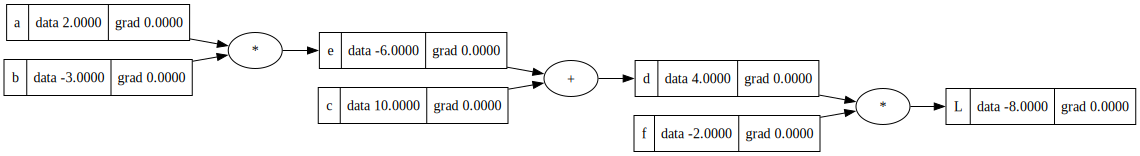

In [29]:
draw_dot(L)

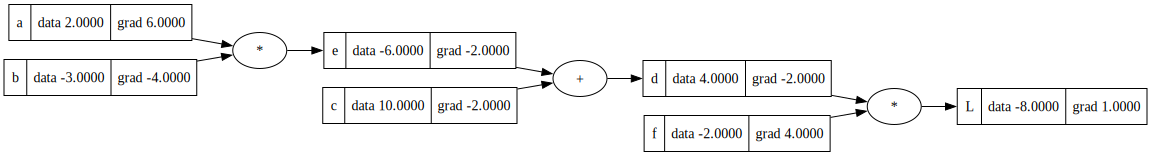

In [30]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = 1.0*d.grad
e.grad = 1.0*d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad

draw_dot(L)

In [31]:
h = 0.01
a.data += h*a.grad
b.data += h*b.grad
c.data += h*c.grad
f.data += h*f.grad

e = a*b
d = e+c
L = d*f 
print(L.data)

-7.286496


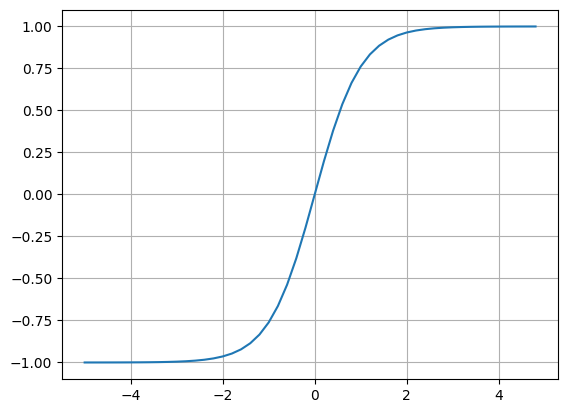

In [32]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

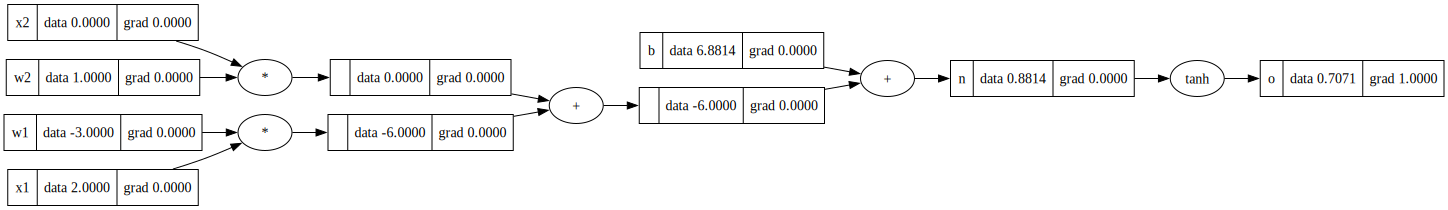

In [48]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

n = x1*w1+x2*w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1.0
draw_dot(o)


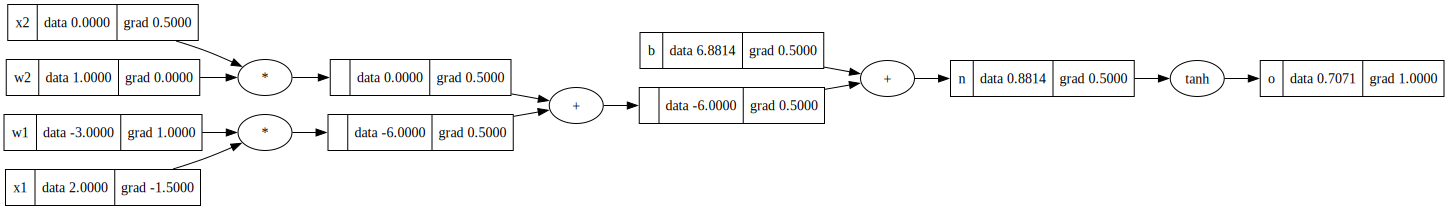

In [ ]:
o.backward()
# n._backward()
draw_dot(o)

In [214]:
import random

class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        # neurons take the same inputs and apply random weights
        # if the weights are same as below, then neuron output is same
        # self.w = [Value(0.5) for _ in range(nin)]
        # self.b = Value(0.3)
    
    def __call__(self,x):
        activation = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        # original number of inputs say 2, with layers of 3,6
        # now you have [2,3,6]
        # first layer is 2 in 3 out, second layer is 3 in 6 out
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        # by reassigning the layer output to x
        # the layers get chained together!
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

a = [1,2,3]
b = [4,5,6]
for i in zip(a,b):
    print (i)

x = [2.0,3.0,-1.0]
# n = Layer(len(x), 3)
# n(x)
n = MLP(len(x),[4,4,1])
n(x)


(1, 4)
(2, 5)
(3, 6)


Value(data=0.1236527892043741)

In [358]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9689124867058586),
 Value(data=-0.9572512354246597),
 Value(data=-0.9744978924849302),
 Value(data=0.9605011280838308)]

In [216]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss.backward()

In [357]:
for i in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))    
    
    # backward pass: need to reset the gradients on each new backward pass    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()    

    # update weights
    for p in n.parameters():
        p.data += -p.grad * 0.01
    
    print(loss)

Value(data=0.005049340031466502)
Value(data=0.005044811276335336)
Value(data=0.005040290493288492)
Value(data=0.005035777661381652)
Value(data=0.005031272759743464)
Value(data=0.005026775767575437)
Value(data=0.005022286664151416)
Value(data=0.0050178054288174834)
Value(data=0.0050133320409914035)
Value(data=0.00500886648016256)
